<a href="https://colab.research.google.com/github/MaximeSzymanski/StocksClusteringVAE/blob/main/VAE_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup


/Users/maximeszymanski/PycharmProjects/StocksClusteringVAE/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

!pip install yfinance
!pip install BeautifulSoup
!pip install requests


  Using cached BeautifulSoup-3.2.2.tar.gz (32 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/pip-install-ml56478h/beautifulsoup_04683c7719da48249dd77733e6f5c606/setup.py", line 3
          "You're trying to run a very old release of Beautiful Soup under Python 3. This will not work."<>"Please use Beautiful Soup 4, available through the pip package 'beautifulsoup4'."
                                                                                                         ^
      SyntaxError: invalid syntax
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-genera

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def download_stocks(ticker_list, start_date='2019-11-08', end_date='2023-11-08'):
    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize an empty list to store normalized values
    normalized_values_list = []
    stocks_kept = []
    iterator = 0
    kept_stocks_with_indexes = []

    # Loop through each stock symbol
    for index, symbol in enumerate(ticker_list):
        try:
            # Download historical stock data using yfinance
            stock_data = yf.download(symbol, start=start_date, end=end_date)

            # Extract the 'Close' column
            close_values = stock_data['Close'].values
            if len(close_values) >= 0:
                # Normalize the data between -1 and 1
                normalized_values = 2 * (close_values - np.min(close_values)) / np.ptp(close_values) - 1
                normalized_values_list.append(normalized_values)
                stocks_kept.append(symbol)
                print(f"stocks {iterator}/{len(ticker_list)}")
                iterator += 1
                kept_stocks_with_indexes.append((index, symbol, normalized_values))
            else:
                # remove the stock if it has not enough data
                print(f"stock {symbol} has not enough data")
                continue
        except Exception as e:
            print(f"Error downloading data for {symbol}: {e}")
            continue

    # get the different lengths of the stocks
    lengths = [len(stock[2]) for stock in kept_stocks_with_indexes]
    lengths_set = set(lengths)

    # get the most common length
    most_common_length = max(set(lengths), key=lengths.count)

    # keep only the stocks with the most common length
    normalized_values_list = [stock[2] for stock in kept_stocks_with_indexes if len(stock[2]) == most_common_length]
    kept_stocks_with_indexes = [(index, symbol) for index, symbol, normalized_values in kept_stocks_with_indexes if len(normalized_values) == most_common_length]

    # length is 1006, so we need to remove the last 6 values for each stock
    normalized_values_list = [normalized_values[:-6] for normalized_values in normalized_values_list]

    return normalized_values_list, kept_stocks_with_indexes

In [4]:
df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise

        a = td[0].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            print(f"ticker : {ticker}")
            ticker_list.append(ticker)

ticker : AAON
ticker : AAP
ticker : AAT
ticker : ABCB
ticker : ABG
ticker : ABM
ticker : ABR
ticker : ACA
ticker : ACIW
ticker : ACLS
ticker : ADEA
ticker : ADTN
ticker : ADUS
ticker : AEIS
ticker : AEL
ticker : AEO
ticker : AGO
ticker : AGTI
ticker : AGYS
ticker : AHCO
ticker : AHH
ticker : AIN
ticker : AIR
ticker : AIT
ticker : AKR
ticker : ALEX
ticker : ALG
ticker : ALGT
ticker : ALRM
ticker : AMBC
ticker : AMCX
ticker : AMEH
ticker : AMN
ticker : AMPH
ticker : AMR
ticker : AMSF
ticker : AMWD
ticker : ANDE
ticker : ANF
ticker : ANIP
ticker : AORT
ticker : AOSL
ticker : APAM
ticker : APLE
ticker : APOG
ticker : APPS
ticker : ARCB
ticker : ARI
ticker : ARLO
ticker : AROC
ticker : ARR
ticker : ASIX
ticker : ASO
ticker : ASTE
ticker : ATEN
ticker : ATGE
ticker : ATI
ticker : ATNI
ticker : AUB
ticker : AVA
ticker : AVAV
ticker : AVNS
ticker : AVTA
ticker : AWR
ticker : AX
ticker : AXL
ticker : AZZ
ticker : B
ticker : BANC
ticker : BANF
ticker : BANR
ticker : BCC
ticker : BCPC
ticker : BD

In [5]:
import os
import pickle

# Check if the file exists
if os.path.exists('stocks_data.pkl'):
    # If the file exists, load it
    with open('stocks_data.pkl', 'rb') as f:
        stocks_data = pickle.load(f)
else:
    # If the file doesn't exist, download the stocks data
    # This is a placeholder for the code to download the stocks data
    # Replace it with the actual code to download the data
    stocks_data = download_stocks(ticker_list)

    # Save the downloaded data into a file
    with open('stocks_data.pkl', 'wb') as f:
        pickle.dump(stocks_data, f)

kept_stocks_with_indexes = stocks_data[1]
normalized_values_list = stocks_data[0]
print(f"kept_stocks_with_indexes : {kept_stocks_with_indexes}")

kept_stocks_with_indexes : [(0, 'AAON'), (1, 'AAP'), (2, 'AAT'), (3, 'ABCB'), (4, 'ABG'), (5, 'ABM'), (6, 'ABR'), (7, 'ACA'), (8, 'ACIW'), (9, 'ACLS'), (10, 'ADEA'), (11, 'ADTN'), (12, 'ADUS'), (13, 'AEIS'), (14, 'AEL'), (15, 'AEO'), (16, 'AGO'), (18, 'AGYS'), (19, 'AHCO'), (20, 'AHH'), (21, 'AIN'), (22, 'AIR'), (23, 'AIT'), (24, 'AKR'), (25, 'ALEX'), (26, 'ALG'), (27, 'ALGT'), (28, 'ALRM'), (29, 'AMBC'), (30, 'AMCX'), (31, 'AMEH'), (32, 'AMN'), (33, 'AMPH'), (35, 'AMSF'), (36, 'AMWD'), (37, 'ANDE'), (38, 'ANF'), (39, 'ANIP'), (40, 'AORT'), (41, 'AOSL'), (42, 'APAM'), (43, 'APLE'), (44, 'APOG'), (45, 'APPS'), (46, 'ARCB'), (47, 'ARI'), (48, 'ARLO'), (49, 'AROC'), (50, 'ARR'), (51, 'ASIX'), (53, 'ASTE'), (54, 'ATEN'), (55, 'ATGE'), (56, 'ATI'), (57, 'ATNI'), (58, 'AUB'), (59, 'AVA'), (60, 'AVAV'), (61, 'AVNS'), (62, 'AVTA'), (63, 'AWR'), (64, 'AX'), (65, 'AXL'), (66, 'AZZ'), (67, 'B'), (68, 'BANC'), (69, 'BANF'), (70, 'BANR'), (71, 'BCC'), (72, 'BCPC'), (73, 'BDN'), (74, 'BFH'), (75, 'B

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Use the previously prepared data
sub_series_length = 200
stock_symbols = [stock[1] for stock in kept_stocks_with_indexes]

# Check that the length of each normalized series is divisible by sub_series_length
number_of_sub_series = len(normalized_values_list[0]) // sub_series_length

for i in range(len(stock_symbols)):
    assert len(normalized_values_list[i]) % sub_series_length == 0

# Create sub-series for each stock
sub_series_list = [normalized_values.reshape((-1, sub_series_length)) for normalized_values in normalized_values_list]

# Convert the list to a numpy array
stocks_np_array = np.zeros((len(stock_symbols), sub_series_list[0].shape[0], sub_series_list[0].shape[1]))
for i in range(len(stock_symbols)):
    stocks_np_array[i] = sub_series_list[i]

# Create a PyTorch Dataset
stock_dataset = StockDataset(stocks_np_array)

# Create a PyTorch DataLoader
batch_size = 32
shuffle = True  # To shuffle the data
data_loader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=shuffle)

# Iterate through the DataLoader to get shuffled batches
for batch in data_loader:
    # Process each batch
    print("Batch shape:", batch.shape)  # Adjust this according to your processing needs
    # Your processing logic here


Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([32, 5, 200])
Batch shape: torch.Size([20, 5, 200])


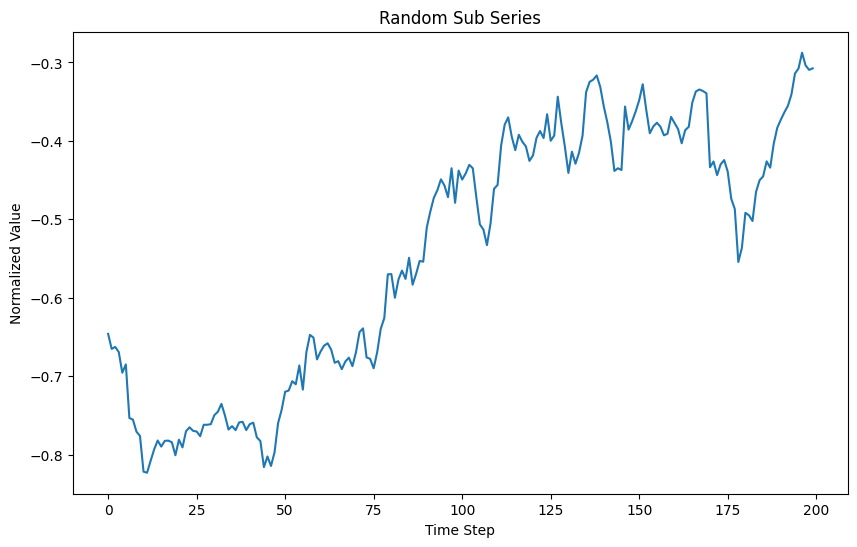

In [7]:
# print a random sub series
number_of_stocks = len(stock_symbols)
random_index_stocks = np.random.randint(0, number_of_stocks)
random_index_sub_series = np.random.randint(0, number_of_sub_series)
plt.figure(figsize=(10, 6))
plt.plot(stocks_np_array[random_index_stocks][random_index_sub_series])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [16]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
class SamplingLayerVAE(nn.Module):
  def __init__(self):
    super(SamplingLayerVAE, self).__init__()

  def forward(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 128,num_heads=8,sub_seq_len=20,
               latent_dim=64):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.chunk_index_embedding = ChunkIndexEmbedding(num_chunks=self.seq_len,embedding_dim=embedding_dim)

    self.mu = nn.Linear((self.sub_seq_len//2)*self.embedding_dim,latent_dim)
    self.log_var = nn.Linear((self.sub_seq_len//2)*self.embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()
    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1


    #self.positional_encoding = PositionalEncoding(embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)
    self.transformer_1 = CompressWithAttentionResidual(input_size=self.hidden_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim*2,
                                             group_size=self.number_of_sub_seq)

    self.transformer_2 = CompressWithAttentionResidual(input_size=embedding_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim,
                                             group_size=2)


  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    original_x = x

    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)

    x = self.chunk_index_embedding(x)
    x, (_, _) = self.rnn1(x)


    x = self.transformer_1(x)
    x = self.transformer_2(x)
    x = x.reshape((batch_size, (self.sub_seq_len//2)*self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var, original_x



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False,
               sub_seq_len=20,latent_dim=64):
    super(Decoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    # number
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.expend_layer_1 = ExpandWithAttentionResidual(input_size=latent_dim,output_size=input_dim,
                                             hidden_size_attention=latent_dim,
                                             group_size=self.sub_seq_len ,expansion_factor=
                                                    self.number_of_sub_seq)

    self.expend_layer_2 = ExpandWithAttentionResidual(input_size=input_dim,output_size=input_dim,
                                             hidden_size_attention=input_dim,
                                             group_size=self.sub_seq_len*self.number_of_sub_seq,expansion_factor=2)

    self.output_embeding = OutputEmbedding(input_dim=self.hidden_dim,seq_len=self.seq_len,output_dim=1)
    self.chunk_index_embedding = ChunkIndexEmbedding(num_chunks=self.seq_len,embedding_dim=input_dim)
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1

  def forward(self, x):

    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.unsqueeze(1)
    x = x.repeat(1, self.sub_seq_len//2, 1)

    x = self.expend_layer_1(x)
    x = self.chunk_index_embedding(x)
    x = self.expend_layer_2(x)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    x = self.output_embeding(x)

    # keep only the last layer


    return x
class ExpandWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size, expansion_factor):
        super(ExpandWithAttentionResidual, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size
        self.expansion_factor = expansion_factor

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.expansion_factor * self.hidden_size,  self.expansion_factor * self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size , self.output_size)
        self.norma = nn.LayerNorm(self.hidden_size)
    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Use attention to expand the input

        x = x.view(batch_size* seq_len , n_features)
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)
        Q = Q.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        K = K.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        V = V.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Apply final linear transformations
        attended_values = attended_values.reshape((batch_size* seq_len , self.expansion_factor * self.hidden_size))
        attention_output = self.attention_output_linear(attended_values)

        # Reshape attention output into groups of size self.group_size
        attention_output = attention_output.view(batch_size, seq_len* self.expansion_factor ,self.hidden_size)

        # Add residual connection
        # repeat the tensor x to have the same shape as attention_output
        # repeat to have from (batch_size, seq_len, n_features) to (batch_size, seq_len* self.expansion_factor ,n_features)
        x = x.view(batch_size, seq_len, n_features)
        x = x.repeat(1, self.expansion_factor, 1)
        out = attention_output + x
        batch_size, expended_seq_len, n_features = out.size()
        # normalize the output
        out = out.reshape((batch_size* expended_seq_len , n_features))
        #out = self.norma(out)

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)
        out = out.reshape((batch_size, expended_seq_len, self.output_size))
        return out

class CompressWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size):
        super(CompressWithAttentionResidual, self).__init__()
        self.input_size = input_size
        print(f"ouput size : {output_size}")
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Reshape input into groups of size self.group_size

        x = x.view(batch_size, -1, self.group_size, n_features)
        group_len = x.size(1)

        # Linear projections for attention
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Sum along the group dimension
        attended_values = attended_values.sum(dim=2)

        # Apply final linear transformations
        attention_output = self.attention_output_linear(attended_values)


        # Add residual connection
        # so, we need to pack the tensor x to have the same shape as attention_output. We have to do : x[i] = x[i] + x[i+1] and so on paired by 2
        group_size = self.group_size

# Create slices and sum them based on the group size
        slices = [x[:, i::group_size, :] for i in range(group_size)]

        x = sum(slices)
        # Final linear transformation

        batch_size_2, sub_series_length, n_features = attention_output.size()


        x = x.reshape((batch_size_2 , sub_series_length, n_features))
        out = attention_output + x

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)
        return out


class ChunkIndexEmbedding(nn.Module):
    def __init__(self,num_chunks=100,embedding_dim=64):
        super(ChunkIndexEmbedding, self).__init__()
        self.num_chunks = num_chunks
        self.embedding = nn.Embedding(self.num_chunks,embedding_dim )

    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        chunk_index = torch.arange(0, seq_len, 1).to(x.device)

        chunk_index = chunk_index.unsqueeze(0).repeat(batch_size, 1)

        chunk_index = self.embedding(chunk_index)

        x = x + chunk_index
        return x

class InputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=1,output_dim=64):
        super(InputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x

class OutputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=64,output_dim=1):
        super(OutputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x




In [15]:
class SimpleEncoderLSTM(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False):
    super(SimpleEncoderLSTM, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )

    self.mu = torch.nn.Linear(self.seq_len * embedding_dim, latent_dim)
    self.log_var = torch.nn.Linear(self.seq_len * embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()



  def forward(self, x):
    original_x = x
    batch_size, seq_len, n_features = x.size()
    #x = x.reshape((batch_size * seq_len, n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = x.reshape((batch_size, self.seq_len, self.embedding_dim))
    x = x.reshape((batch_size, self.seq_len * self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var, x, original_x

class SimpleDecoderLSTM(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False):
    super(SimpleDecoderLSTM, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.repeat(1, self.seq_len, 1)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    # keep only the last layer


    return self.output_layer(x)


In [ ]:
class RecurrentAutoencoder_LSTM(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder_LSTM, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = SimpleEncoderLSTM(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1).to(device)
    self.decoder = SimpleDecoderLSTM(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.Tanh()(x)
    return x



In [ ]:
model = RecurrentAutoencoder_LSTM(sub_series_length, 1, 64)
print(f"model : {model}")

In [9]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=128,sub_seq_len=10,latent_dim=2):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
  def forward(self, x):
    z, mu, sigma, original_x = self.encoder(x)
    x = self.decoder(z)
    x = nn.Tanh()(x)
    return x, original_x, mu, sigma

In [17]:
print(f"sub_series_length : {sub_series_length}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32
model = RecurrentAutoencoder(sub_series_length, 1, 32,sub_seq_len=100,latent_dim=latent_dim).to(device)

sub_series_length : 200
ouput size : 32
ouput size : 32


In [18]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (chunk_index_embedding): ChunkIndexEmbedding(
      (embedding): Embedding(200, 32)
    )
    (mu): Linear(in_features=1600, out_features=32, bias=True)
    (log_var): Linear(in_features=1600, out_features=32, bias=True)
    (sampling_layer): SamplingLayerVAE()
    (rnn1): LSTM(32, 32, batch_first=True, bidirectional=True)
    (embedding_layer): Linear(in_features=1, out_features=32, bias=True)
    (transformer_1): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=64, out_features=64, bias=True)
      (K_linear): Linear(in_features=64, out_features=64, bias=True)
      (V_linear): Linear(in_features=64, out_features=64, bias=True)
      (attention_output_linear): Linear(in_features=64, out_features=64, bias=True)
      (output_linear): Linear(in_features=64, out_features=32, bias=True)
    )
    (transformer_2): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=32, out_features=32, bias=True)
      (K_l

In [30]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(x, y):

    return nn.MSELoss(reduction='mean')(x,y)

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-1):
    reconstruction  = reconstruction_loss(x, original_x)
    kl = KL_loss(mu, sigma)
    return k1 * reconstruction + k2 * kl  , reconstruction, kl


In [31]:
# Convert the numpy array to a PyTorch tensor
# The shape is : (number_of_stocks, number_of_sub_series, sub_series_length, features)
# We need to reshape it to (number_of_stocks * number_of_sub_series, sub_series_length, features)
number_of_stocks = stocks_np_array.shape[0]


stocks_np_array_test = stocks_np_array.reshape((number_of_stocks*number_of_sub_series, sub_series_length, 1))
signal_to_tensor = torch.from_numpy(stocks_np_array_test).float().to(device)

# Forward pass through the model
x, original_x, mu, sigma = model(signal_to_tensor)

# Reconstruct the good output shape
x = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))


In [32]:
# load from cuda to cpu
#model = torch.load("model.pth",map_location=torch.device('cpu'))

random stocks : [143 120 276 358 406]
random sub series : [1 1 4 0 2]


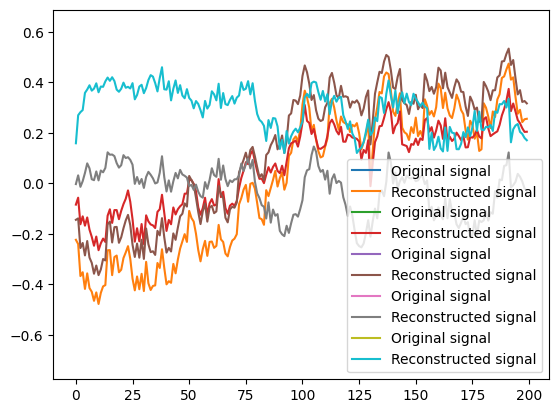

In [33]:
# Plot the reconstruction
# Plot 10 random stocks
number_of_stocks_to_plot = 5
random_stocks = np.random.randint(0, number_of_stocks, number_of_stocks_to_plot)
print(f"random stocks : {random_stocks}")
# Plot 10 random sub-series
random_sub_series = np.random.randint(0, number_of_sub_series, number_of_stocks_to_plot)
print(f"random sub series : {random_sub_series}")
# Plot the original and reconstructed signals
for i in range(number_of_stocks_to_plot):
    plt.plot(original_x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Original signal')
    plt.plot(x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Reconstructed signal')
plt.legend()
plt.show()



Epoch: 0, loss: 0.23637790977954865


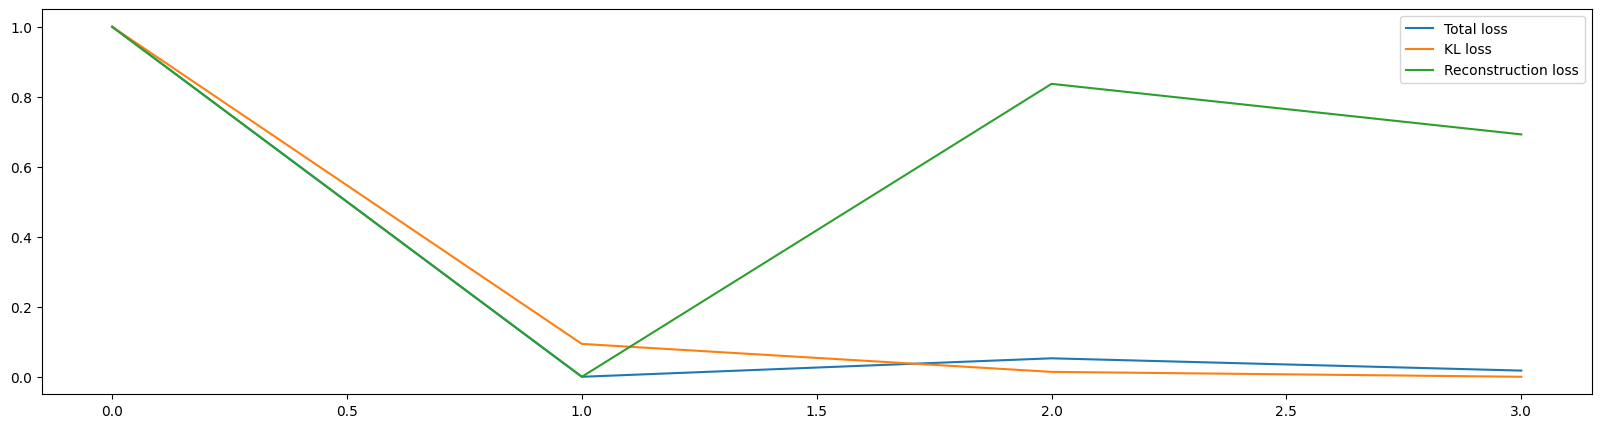

In [36]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
batch_size = 32
shuffle = True  # To shuffle the data
data_loader = DataLoader(stocks_np_array, batch_size=batch_size, shuffle=shuffle)
loss_list_KL = []
loss_list_reconstruction = []
loss_list = []
#loss_fn = nn.L1Loss(reduction='sum')

for epoch in range(4):
    epoch_loss_KL = 0
    epoch_loss_reconstruction = 0
    epoch_loss = 0
    for batch in data_loader:
        # Process each batch
        #print("Batch shape:", batch.shape)  # Adjust this according to your processing needs
        batch = batch.to(device)
        batch = batch.to(torch.float32)
        batch_size_current = batch.shape[0]
        batch = batch.reshape((batch_size_current*number_of_sub_series, sub_series_length, 1))
        # Your processing logic here
        optimizer.zero_grad()
        x, original_x, mu, sigma = model(batch)
        total_loss,reconstruction_l,KL_l = loss_function(x, original_x, mu, sigma)
        total_loss.backward()
        optimizer.step()
        epoch_loss_KL += KL_l.item()
        epoch_loss_reconstruction += reconstruction_l.item()
        epoch_loss += total_loss.item()
    loss_list_KL.append(epoch_loss_KL)
    loss_list_reconstruction.append(epoch_loss_reconstruction)
    loss_list.append(epoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {total_loss.item()}')
# plot the loss, KL and reconstruction in 3 different color on the same plot
# normalize loss between 0 and 1
loss_list = np.array(loss_list)
loss_list = (loss_list - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))
loss_list_KL = np.array(loss_list_KL)
loss_list_KL = (loss_list_KL - np.min(loss_list_KL)) / (np.max(loss_list_KL) - np.min(loss_list_KL))
loss_list_reconstruction = np.array(loss_list_reconstruction)
loss_list_reconstruction = (loss_list_reconstruction - np.min(loss_list_reconstruction)) / (np.max(loss_list_reconstruction) - np.min(loss_list_reconstruction))
plt.figure(figsize=(20, 5))
plt.plot(loss_list, label='Total loss')
plt.plot(loss_list_KL, label='KL loss')
plt.plot(loss_list_reconstruction, label='Reconstruction loss')
plt.legend()
plt.show()


x shape : (2820, 200, 1)
number_of_stocks : 564
number_of_sub_series : 5
sub_series_length : 200
stocks_np_array_reshaped shape : (564, 5, 200)


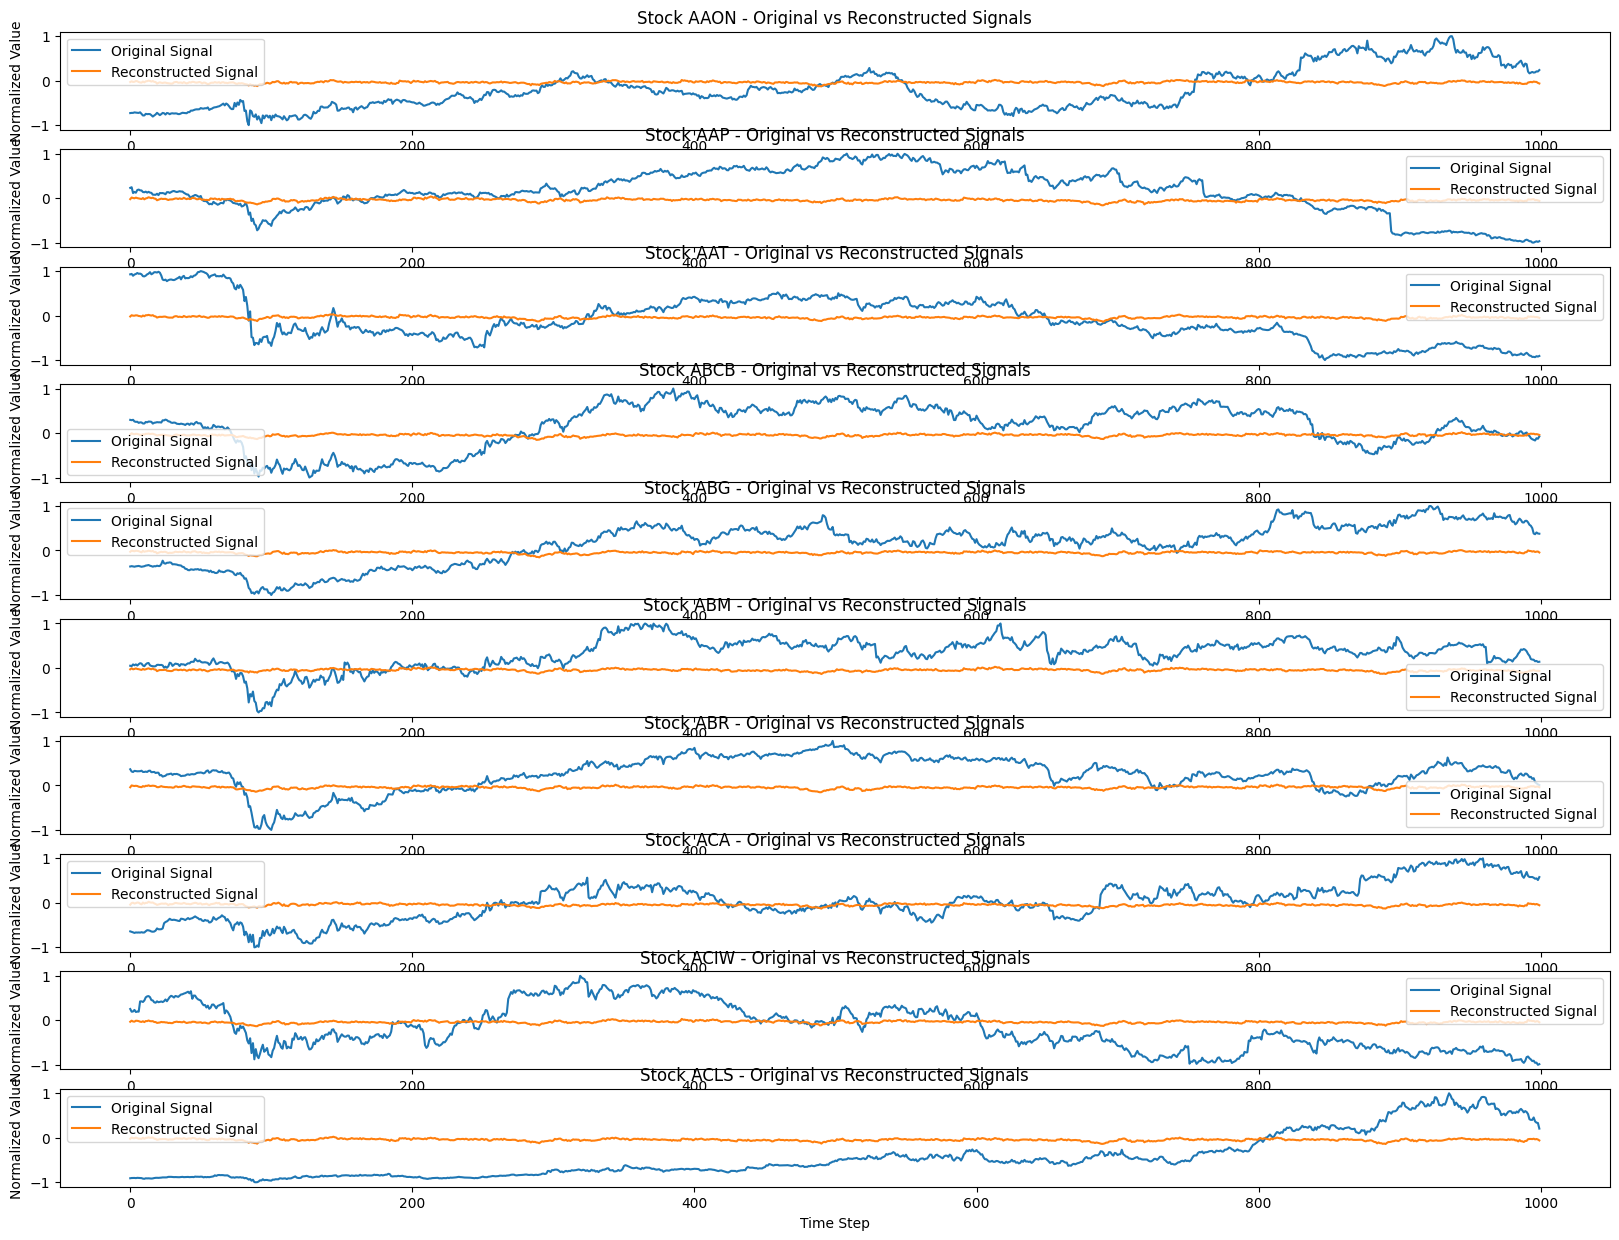

In [37]:
import matplotlib.pyplot as plt
with torch.no_grad():
    x, original_x, mu, sigma = model(signal_to_tensor)
    x = x.cpu().detach().numpy()
print(f"x shape : {x.shape}")
# Plot the reconstruction of all signals
stocks_kept= [stock[1] for stock in kept_stocks_with_indexes]
stocks_to_plot = 10
# Reshape the data
print(f"number_of_stocks : {number_of_stocks}")
print(f"number_of_sub_series : {number_of_sub_series}")
print(f"sub_series_length : {sub_series_length}")
stocks_np_array_reshaped = stocks_np_array.reshape((number_of_stocks, number_of_sub_series, sub_series_length))
reconstructed_signals_reshaped = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))
print(f"stocks_np_array_reshaped shape : {stocks_np_array_reshaped.shape}")
# Plot each stock in separate subplots
plt.figure(figsize=(20, 15))

for i in range(stocks_to_plot):
    plt.subplot(stocks_to_plot, 1, i + 1)
    plt.plot(stocks_np_array_reshaped[i].reshape((-1, 1)), label='Original Signal')
    plt.plot(reconstructed_signals_reshaped[i].reshape((-1, 1)), label='Reconstructed Signal')
    plt.title(f'Stock {stocks_kept[i]} - Original vs Reconstructed Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()


plt.show()


signals_latent shape : (2820, 32)
latent_space_np_array shape : (564, 5, 2)


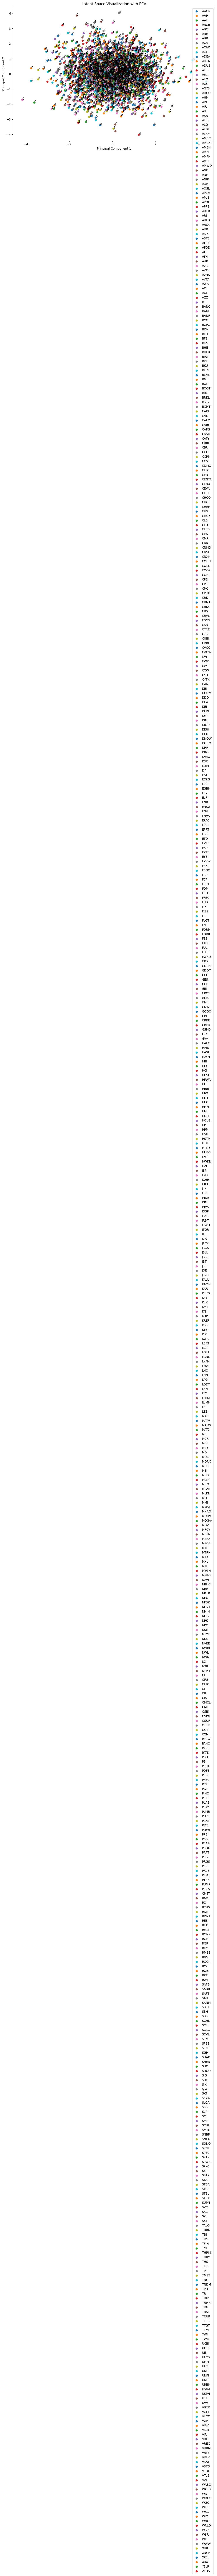

In [38]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility


with torch.no_grad():
    signals_latent,_,_,_ = model.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
print(f"signals_latent shape : {signals_latent.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent)
# Reshape the latent space for each stock

latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, number_of_sub_series, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[:, 0], latent_space_stock[:, 1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[j, 0], latent_space_stock[j, 1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility

print(signal_to_tensor.shape)
with torch.no_grad():
    signals_latent,_,_,_ = model.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
    print(signals_latent.shape)
signals_latent_sumed = signals_latent.reshape(number_of_stocks,number_of_sub_series,latent_dim )

signals_latent_sumed = np.sum(signals_latent_sumed, axis=(1))

print(f"signals_latent shape : {signals_latent_sumed.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent_sumed)
# Reshape the latent space for each stock
print(latent_space.shape)
latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[0], latent_space_stock[1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[0], latent_space_stock[1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Apply K-means to the latent space
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 42
K_means_PCA = KMeans(n_clusters=8, random_state=seed)
K_means_PCA.fit(latent_space_np_array)
inertia_Kmeans_PCA = K_means_PCA.inertia_
plt.figure(figsize=(12, 8))
plt.scatter(latent_space_np_array[:, 0], latent_space_np_array[:, 1], c=K_means_PCA.labels_, cmap='rainbow')
plt.scatter(K_means_PCA.cluster_centers_[:, 0], K_means_PCA.cluster_centers_[:, 1], color='black')
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [ ]:
 # Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model_bis = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model_bis, k=(2,30), timings= True)
# Fit data to visualizer
visualizer.fit(latent_space_np_array)
visualizer.show()        # Finalize and render figure

In [ ]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
models = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(models, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(latent_space_np_array)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
cluster_to_plot = 0
# Plot the signals in the cluster
plt.figure(figsize=(20, 5))
for i, cluster in enumerate(K_means_PCA.labels_):
    if cluster == cluster_to_plot:
        plt.plot(stocks_np_array_reshaped[i].reshape((-1, 1)), label=f'{stock_symbols[i]}')
plt.title(f'Stocks in Cluster {cluster_to_plot}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [ ]:
# interpolate between two signales
# take the first signal
print(f"latent_signal_np_array shape : {signals_latent.shape}")
signals_latent = signals_latent.reshape((number_of_stocks, number_of_sub_series, latent_dim))

signal_1_index,signal_1_name = 79, stock_symbols[79]

signal_2_index ,signal_2_name = 43, stock_symbols[43]
signal_1 = signals_latent[signal_1_index]
signal_2 = signals_latent[signal_2_index]

# define the number of points to interpolate
number_of_points = signal_1.shape[0]
print(f"number_of_points : {number_of_points}")
print(f"signal_1 shape : {signal_1.shape}")
print(f"signal_2 shape : {signal_2.shape}")
new_signal = np.zeros((number_of_points,latent_dim))

for i in range(number_of_points):


    new_signal[i] = (signal_1[i] + (signal_2[i]) ) / 2

# apply PCA to the new signal
#pca = PCA(n_components=2)
#
# plot the latent space with the 3 signals in different colors
#latent_space_new_signal = pca.fit_transform(new_signal)
latent_space_new_signal = new_signal
plt.scatter(signal_1[:,0],signal_1[:,1],label=signal_1_name)
plt.scatter(signal_2[:,0],signal_2[:,1],label=signal_2_name)
plt.scatter(latent_space_new_signal[:,0],latent_space_new_signal[:,1],label='new signal')
for i in range(number_of_points):
    plt.annotate(str(i), (signal_1[i, 0], signal_1[i, 1]))
    plt.annotate(str(i), (signal_2[i, 0], signal_2[i, 1]))
    plt.annotate(str(i), (latent_space_new_signal[i, 0], latent_space_new_signal[i, 1]))
plt.legend()
plt.show()

In [ ]:
# decode the new signal
new_signal = torch.from_numpy(new_signal).float().to(device)
new_signal = new_signal.squeeze()
print(f"new signal shape : {new_signal.shape}")
with torch.no_grad():
    new_signal_decoded = model.decoder(new_signal)
    new_signal_decoded = nn.Tanh()(new_signal_decoded)
    new_signal_decoded = new_signal_decoded.squeeze().cpu().detach().numpy()
print(f"new signal decoded shape : {new_signal_decoded.shape}")
new_signal_decoded = new_signal_decoded.reshape((number_of_sub_series*sub_series_length,1))

stocks_array_flatten = stocks_np_array.reshape((number_of_stocks,number_of_sub_series*sub_series_length,1))
print(f"stocks_array_flatten shape : {stocks_array_flatten.shape}")
# plot the new signal decoded, the first signal and the second signal
plt.figure(figsize=(20, 15))
plt.plot(stocks_array_flatten[signal_1_index],label=signal_1_name)
plt.plot(stocks_array_flatten[signal_2_index],label=signal_2_name)
plt.plot(new_signal_decoded,label='new signal decoded')
plt.legend()
plt.show()
